<a href="https://colab.research.google.com/github/ray-hu/EM-Segmentation/blob/master/U_Net_EM_aug_Keras_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

### **Install Pytorch**

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/cu80/torch-0.2.0.post2-cp36-cp36m-manylinux1_x86_64.whl torchvision # http://download.pytorch.org/whl/{accelerator}/torch-0.2.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.2.0_2
True


In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


### **Upgrading Tensorflow**

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
#!pip install tensorflow

# For the latest nightly build:
#!pip install tf-nightly

Name: tensorflow
Version: 1.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, six, numpy, grpcio, keras-preprocessing, gast, wheel, keras-applications, termcolor, tensorboard, protobuf, astor
Required-by: 
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.12.0)


### **Import Keras**

In [0]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [0]:
!pip install Keras

In [0]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.2.4


### **Import other libraries**

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image
# Restart then PIL will have no error

    100% |████████████████████████████████| 5.6MB 4.4MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL
    100% |████████████████████████████████| 7.3MB 5.3MB/s 


### Upload dataset to your google drive
./My\ Drive/data

### **Mounting Google Drive locally**

In [0]:
from google.colab import drive
drive.mount('./GoogleDrive')

Drive already mounted at ./GoogleDrive; to attempt to forcibly remount, call drive.mount("./GoogleDrive", force_remount=True).


In [0]:
#!rm drive

In [0]:
! ln -s GoogleDrive/My\ Drive ./drive

In [0]:
! ls

In [0]:
#! ls drive/EM/train-volume.tif

# **Data Augmentation**

In [0]:
import os
import glob
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img

In [0]:
train_imgs_path = glob.glob("drive/data/train"+"/*."+"tif")
label_imgs_path = glob.glob("drive/data/label"+"/*."+"tif")
test_imgs_path = glob.glob("drive/data/test"+"/*."+"tif")

print("We have {} training images in total.".format(len(train_imgs_path)))
print("We have {} training labels in total.".format(len(label_imgs_path)))
print("We have {} testing images in total.".format(len(test_imgs_path)))
if len(train_imgs_path) != len(label_imgs_path) or len(train_imgs_path) == 0:
        print ("num of trains can't match num of labels")

We have 30 training images in total.
We have 30 training labels in total.
We have 30 testing images in total.


Showing the orginal data:


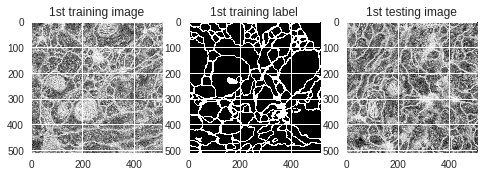

In [0]:
# show the original images
print('Showing the orginal data:')
from skimage import io
image_train = io.imread(train_imgs_path[0])
label_train = io.imread(label_imgs_path[0])
image_test = io.imread(test_imgs_path[0])
f, ax = plt.subplots(1,3)
ax[0].imshow(image_train)
ax[0].set_title('1st training image')
ax[1].imshow(label_train)
ax[1].set_title('1st training label')
ax[2].imshow(image_test)
ax[2].set_title('1st testing image')
plt.show()

In [0]:
# creat folder for the augmentation
path_aug = "drive/data/aug"
if not os.path.lexists(path_aug):
  os.mkdir(path_aug)
savedir = path_aug + "/train"
if not os.path.lexists(savedir):
  os.mkdir(savedir)
savedir = path_aug + "/label"
if not os.path.lexists(savedir):
  os.mkdir(savedir)

In [0]:

def data_augmentation(path_aug='drive/data/aug'):
    
	#read images
    train_path="drive/data/train"
    label_path="drive/data/label"
    img_type="tif"
    train_imgs = glob.glob(train_path+"/*."+img_type)
    label_imgs = glob.glob(label_path+"/*."+img_type)
    slices = len(train_imgs)
    
   # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(rotation_range=10,shear_range=0.1,zoom_range=0.1,horizontal_flip=True,vertical_flip=True,fill_mode='constant',cval=0)
	# merge label and train
    print('Using real-time data augmentation.')
    #one by one augmentation
    for i in range(slices):
        img_t = load_img(train_path+"/"+str(i)+".tif",grayscale=True)
        img_l = load_img(label_path+"/"+str(i)+".tif",grayscale=True)
        x_t = img_to_array(img_t)
        x_l = img_to_array(img_l)
        s=np.shape(x_t)
        img = np.ndarray(shape=(s[0],s[1],3),dtype=np.uint8)
      
        img[:,:,0]=x_t[:,:,0]
        img[:,:,2]=x_l[:,:,0]
        	# here's a more "manual" example
        img = img.reshape((1,) + img.shape)
        batches = 0
        for batch in datagen.flow(img, batch_size=1,save_to_dir=path_aug,save_prefix=str(i),save_format='tif'):
            batches += 1
            if batches >= 30:
                break
            # we need to break the loop by hand because
            # the generator loops indefinitely
    aug_imgs = glob.glob(path_aug+"/*.tif")
    savedir = path_aug + "/train"
    if not os.path.lexists(savedir):
        os.mkdir(savedir)
    savedir = path_aug + "/label"
    if not os.path.lexists(savedir):
        os.mkdir(savedir)
    i=0
    for imgname in aug_imgs:
        img =load_img(imgname)
        img=img_to_array(img)
       
        img_train = img[:,:,:1]
        img_label = img[:,:,2:]
        img_train = array_to_img(img_train)
        img_label = array_to_img(img_label)
        img_train.save(path_aug+"/train/"+str(i)+".tif")
        img_label.save(path_aug+"/label/"+str(i)+".tif")
        i+=1

In [0]:
data_augmentation()

Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


# **Build a Unet(Keras)**

In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.35.218.2:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 16539708815004170494),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16166505490163249097),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 5195639315914122011),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 6901611878338809983),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 1568508519181974775),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2915909029902550766),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 6256546957279800839),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 7244416277926508870),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 3789771

In [0]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import tensorflow as tf
#from tensorflow.keras.models import *
#from keras.layers.merge import concatenate
#from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
#from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def Unet(img_rows=512,img_cols=512):
  inputs = tf.keras.layers.Input((img_rows, img_cols,1))
  
  conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = tf.keras.layers.Dropout(0.5)(conv4)
  pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)
  conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = tf.keras.layers.Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = tf.keras.layers.Dropout(0.5)(conv5)
  up6 = tf.keras.layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(drop5))
  merge6 = tf.keras.layers.concatenate([drop4,up6],axis = 3)
  conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = tf.keras.layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
  up7 = tf.keras.layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv6))
  merge7 = tf.keras.layers.concatenate([conv3,up7],axis = 3)
  conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
  up8 = tf.keras.layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv7))
  merge8 = tf.keras.layers.concatenate([conv2,up8],axis = 3)
  conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
  
  up9 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(tf.keras.layers.UpSampling2D(size = (2,2))(conv8))
  merge9 = tf.keras.layers.concatenate([conv1,up9],axis = 3)
  conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = tf.keras.layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = tf.keras.layers.Conv2D(1, 1, activation = 'sigmoid')(conv9)
  model = tf.keras.Model(inputs = inputs, outputs = conv10)
  model.compile(optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model

In [0]:
import os
def train(imgs_train, imgs_mask_train,batch_size,n_epoch):
  tf.keras.backend.clear_session()
  tpu_model = Unet()
  print("got unet")
  #tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy = tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])))

  
  #tpu_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=1e-4, ),loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy'])
  
  
  model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss',verbose=1, save_best_only=True)
  print('Fitting model...')
  #def train_gen(batch_size):
  #while True:
    #offset = np.random.randint(0, imgs_train.shape[0] - batch_size)
    #yield imgs_train[offset:offset+batch_size], imgs_mask_train[offset:offset + batch_size]
    

  #tpu_model.fit_generator(train_gen(batch_size),epochs=n_epoch,steps_per_epoch=100,validation_data=(x_test, y_test))
  tpu_model.fit(imgs_train, imgs_mask_train, epochs=n_epoch)
  tpu_model.save_weights('drive/data/u-net-em-1/bard.h5', overwrite=True)

In [0]:
path_aug = "drive/data"
if not os.path.lexists(path_aug):
  os.mkdir(path_aug)
savedir = path_aug + "/results"
if not os.path.lexists(savedir):
  os.mkdir(savedir)

In [0]:
from keras.preprocessing.image import img_to_array, load_img,array_to_img
import numpy as np 
import glob
#import cv2
#from libtiff import TIFF



class dataProcess(object):
	def __init__(self, out_rows, out_cols, data_path = "drive/data/train", label_path = "drive/data/label",
               test_path = "drive/data/test",aug_path = "drive/data/aug", npy_path = "drive/data/results", img_type = "tif"):

		self.out_rows = out_rows
		self.out_cols = out_cols
		self.data_path = data_path
		self.label_path = label_path
		self.img_type = img_type
		self.test_path = test_path
		self.npy_path = npy_path
		self.aug_path= aug_path

	def create_train_data(self):
		i = 0
		print('-'*30)
		print('Creating training images...')
		print('-'*30)
		imgs = glob.glob(self.data_path+"/*."+self.img_type)
		augimgs = glob.glob(self.aug_path+"/train/*."+self.img_type)
		print("original images",len(imgs))
		print("augmented images",len(augimgs))
		imgdatas = np.ndarray((len(imgs)+len(augimgs),self.out_rows,self.out_cols,1), dtype=np.uint8)
		imglabels = np.ndarray((len(imgs)+len(augimgs),self.out_rows,self.out_cols,1), dtype=np.uint8)
		for imgname in imgs:
			midname = imgname[imgname.rindex("/")+1:]
			img = load_img(self.data_path + "/" + midname,grayscale = True)
			label = load_img(self.label_path + "/" + midname,grayscale = True)
			img = img_to_array(img)
			label = img_to_array(label)
			imgdatas[i] = img
			imglabels[i] = label
			if i % 100 == 0:
				print('Done: {0}/{1} images'.format(i, len(imgs)+len(augimgs)))
			i += 1
		for imgname in augimgs:
			midname = imgname[imgname.rindex("/")+1:]
			img = load_img(self.aug_path + "/train/" + midname,grayscale = True)
			label = load_img(self.aug_path + "/label/" + midname,grayscale = True)
			img = img_to_array(img)
			label = img_to_array(label)
			imgdatas[i] = img
			imglabels[i] = label
			if i % 100 == 0:
				print('Done: {0}/{1} images'.format(i, len(imgs)+len(augimgs)))
			i += 1
		print('loading done')
		np.save(self.npy_path + '/imgs_train.npy', imgdatas)
		np.save(self.npy_path + '/imgs_mask_train.npy', imglabels)
		print('Saving to .npy files done.')

	def create_test_data(self):
		print('-'*30)
		print('Creating test images...')
		print('-'*30)
		imgs = glob.glob(self.test_path+"/*."+self.img_type)
		print(len(imgs))
		imgdatas = np.ndarray((len(imgs),self.out_rows,self.out_cols,1), dtype=np.uint8)
		for ind in range(len(imgs)):
			
			img = load_img(self.test_path + "/" +str(ind)+".tif",grayscale = True)
			img = img_to_array(img)
			#img = cv2.imread(self.test_path + "/" + midname,cv2.IMREAD_GRAYSCALE)
			#img = np.array([img])
			imgdatas[ind] = img
			ind += 1
		print('loading done')
		np.save(self.npy_path + '/imgs_test.npy', imgdatas)
		print('Saving to imgs_test.npy files done.')

	def load_train_data(self):
		print('-'*30)
		print('load train images...')
		print('-'*30)
		imgs_train = np.load(self.npy_path+"/imgs_train.npy")
		imgs_mask_train = np.load(self.npy_path+"/imgs_mask_train.npy")
		imgs_train = imgs_train.astype('float32')
		imgs_mask_train = imgs_mask_train.astype('float32'); imgs_train /= 255.; imgs_mask_train /= 255.
		imgs_mask_train[imgs_mask_train > 0.5] = 1
		imgs_mask_train[imgs_mask_train <= 0.5] = 0
		return imgs_train,imgs_mask_train

	def load_test_data(self):
		print('-'*30)
		print('load test images...')
		print('-'*30)
		imgs_test = np.load(self.npy_path+"/imgs_test.npy")
		imgs_test = imgs_test.astype('float32')
		imgs_test /= 255
		#mean = imgs_test.mean(axis = 0)
		#imgs_test -= mean	
		return imgs_test
if __name__ == "__main__":


	mydata = dataProcess(512,512)
	mydata.create_train_data()
	mydata.create_test_data()
	

Using TensorFlow backend.


------------------------------
Creating training images...
------------------------------
original images 30
augmented images 1794
Done: 0/1824 images


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done: 100/1824 images
Done: 200/1824 images
Done: 300/1824 images
Done: 400/1824 images
Done: 500/1824 images
Done: 600/1824 images
Done: 700/1824 images
Done: 800/1824 images
Done: 900/1824 images
Done: 1000/1824 images
Done: 1100/1824 images
Done: 1200/1824 images
Done: 1300/1824 images
Done: 1400/1824 images
Done: 1500/1824 images
Done: 1600/1824 images
Done: 1700/1824 images
Done: 1800/1824 images
loading done
Saving to .npy files done.
------------------------------
Creating test images...
------------------------------
30
loading done
Saving to imgs_test.npy files done.


In [0]:
mydata = dataProcess(512,512)
imgs_train, imgs_mask_train = mydata.load_train_data()
imgs_test = mydata.load_test_data()

------------------------------
load train images...
------------------------------
------------------------------
load test images...
------------------------------


In [0]:
print(imgs_train.shape)
print(imgs_mask_train.shape)

(1824, 512, 512, 1)
(1824, 512, 512, 1)


In [0]:
train(imgs_train, imgs_mask_train, batch_size=4, n_epoch=10)

got unet
Fitting model...
Epoch 1/10


In [0]:
def testing(imgs_test):
	print('predict test data')
	imgs_mask_test = model.predict(imgs_test, batch_size=4, verbose=1)
	np.save(self.save_path+ "imgs_mask_test.npy", imgs_mask_test)
	print("array to image")
	imgs = np.load(self.save_path+"imgs_mask_test.npy")
	print(imgs.shape[0])
	for i in range(imgs.shape[0]):
		img = imgs[i]
		img[img > 0.5] = 1
		img[img<= 0.5] = 0
		img = array_to_img(img)
		img.save("./results/seg/"+ str(i)+".tif")

In [0]:
! mkdir drive/data/u-net-em-1

mkdir: cannot create directory ‘drive/data/u-net-em-1’: File exists


In [0]:
net = Unet()
train(net, imgs_train, groundTruth_train, n_epoch=1, batch_size=1)

# Test

### Load test data and trained model

In [0]:
import numpy as np
from skimage import io
from skimage import data_dir

image_test = io.imread_collection('drive/data/test/*.tif').concatenate()

imgs_test = image_test[:,np.newaxis,...]/225.

In [0]:
! ls drive/data/u-net-em-1

In [0]:
net = Unet()
net.load_state_dict(torch.load('drive/EM/u-net-em-1/params-13-3.782213229686022.pkl'))

In [0]:
def test(net, imgs):
  net.eval()
  img_size = 512
  imgs = np.asarray(imgs).reshape(len(imgs), 1, img_size, img_size)
  pred = net(imgs)
  return pred
    

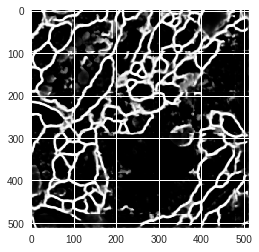

In [0]:
plt.imshow(pred[0][0])

In [0]:
results = np.squeeze(pred)
results = results.astype(np.float16)
io.imsave('drive/data/results.tif', results)

In [0]:
results = results.astype(np.float16)

In [0]:
io.imsave('drive/data/results.tif', results)